## Deep Convolutional Generative Adversarial Networks

In [1]:
# Import stuff
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Set random seed
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Set directory for tensorboard logs
log_dir = './logs/dcgan_test'
writer = SummaryWriter(log_dir)

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Define transformations to be applied to the data
compose = transforms.Compose([
    transforms.Resize(64), 
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# Load the CIFAR10 data
DATA_PATH = './data/CIFAR10'
data = datasets.CIFAR10(DATA_PATH, train=True, transform=compose, download=True)

# Create data loader
batch_size = 100
data_loader = DataLoader(data, batch_size=batch_size, shuffle=True, num_workers=1)
num_batches = len(data_loader)

Files already downloaded and verified


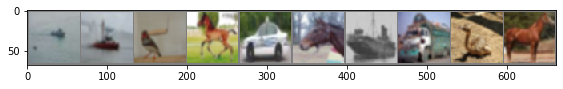

['ship', 'ship', 'bird', 'horse', 'automobile', 'horse', 'ship', 'truck', 'bird', 'horse']


In [3]:
# Utility function to convert label numbers to meaningful words
def labels_to_words(labels):
    meaningful_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    words = []
    for label in labels.numpy():
        words.append(meaningful_labels[label])
    return words

# Utility function to display an image
def imshow(image, figsize=[10,1]):
    image = image * 0.5 + 0.5  # un-normalize
    np_image = image.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np_image, cmap='gray')
    plt.show()
    
# Utility function to sample random images from the dataset and then display them
def sampleshow(n_samples=10, samples_per_row=10):
    loader = DataLoader(data, batch_size=n_samples, shuffle=True, num_workers=1)
    images, labels = iter(loader).next()
    images_grid = utils.make_grid(images, nrow=samples_per_row).permute(1, 2, 0)
    imshow(images_grid, figsize=[samples_per_row, np.ceil(n_samples/samples_per_row)])
    print(labels_to_words(labels))
    
sampleshow()

In [4]:
# Define the discriminator's network
class DiscriminatorNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True)  # Q: Why no dropout?
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024*4*4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.shape[0], -1)
        x = self.out(x)
        return x

In [5]:
# Define the generator's network
class GeneratorNet(nn.Module):
    def __init__(self):
        super().__init__()
        n_features = 100
        
        self.linear = torch.nn.Linear(n_features, 1024*4*4)
        
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)  # Q: Why use ReLU instead of LeakyReLU?
        )
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.convt4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=3, kernel_size=4, stride=2, padding=1, bias=False)
        )
        
        self.out = torch.nn.Tanh()
        
    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        x = self.convt1(x)
        x = self.convt2(x)
        x = self.convt3(x)
        x = self.convt4(x)
        x = self.out(x)
        return x

In [6]:
# Various utility functions
def generate_noise(size):
    return torch.randn(size, 100, device=device)

def real_target(size):
    return torch.ones(size, 1, device=device)

def fake_target(size):
    return torch.zeros(size, 1, device=device)

In [7]:
# Initialize networks
discriminator = DiscriminatorNet().to(device)
generator = GeneratorNet().to(device)

# Create optimizers
d_learning_rate = 0.0002
g_learning_rate = 0.0002
d_betas = (0.5, 0.999)
g_betas = (0.5, 0.999)
d_optimizer = optim.Adam(discriminator.parameters(), lr=d_learning_rate, betas=d_betas)
g_optimizer = optim.Adam(generator.parameters(), lr=g_learning_rate, betas=g_betas)

# Specify loss function
loss = nn.BCELoss()

In [8]:
# Function to train the discriminator once
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Train on real data
    prediction_real = discriminator(real_data)
    
    # Calculate error and propagate backward
    error_real = loss(prediction_real, real_target(real_data.shape[0]))
    error_real.backward(retain_graph=True)
    
    # Train on fake data
    prediction_fake = discriminator(fake_data)
    
    # Calculate error and propagate backward
    error_fake = loss(prediction_fake, fake_target(fake_data.shape[0]))
    error_fake.backward()
    
    # Optimize!
    optimizer.step()
    
    # Calculate accuracy
    accuracy = ((prediction_real >= 0.5).sum() + (prediction_fake < 0.5).sum()).double() / (len(prediction_real) + len(prediction_fake))
    
    # Return error, predictions, and accuracy
    return error_real + error_fake, prediction_real, prediction_fake, accuracy
    
# Function to train the generator once
def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Get discriminator's prediction
    prediction = discriminator(fake_data)
    
    # Calculate error and propagate backward
    error = loss(prediction, real_target(fake_data.shape[0]))
    error.backward()
    
    # Optimize!
    optimizer.step()
    
    # Return error
    return error

In [9]:
# Autosave settings
save_interval = 100
d_save_path = 'models/dcgan_discriminator_v0.pth'
g_save_path = 'models/dcgan_generator_v0.pth'
load_parameters_before_training = True

if load_parameters_before_training:
    if os.path.exists(d_save_path):
        discriminator.load_state_dict(torch.load(d_save_path))
        print("Discriminator loaded successfully")
    if os.path.exists(g_save_path):
        generator.load_state_dict(torch.load(g_save_path))
        print("Generator loaded successfully")

Epoch 0 	Batch 0 	Accuracy 0.5650000000000001
Epoch 0 	Batch 1 	Accuracy 0.47500000000000003
Epoch 0 	Batch 2 	Accuracy 0.605
Epoch 0 	Batch 3 	Accuracy 0.495
Epoch 0 	Batch 4 	Accuracy 0.9
Epoch 0 	Batch 5 	Accuracy 0.535
Epoch 0 	Batch 6 	Accuracy 0.835
Epoch 0 	Batch 7 	Accuracy 0.665
Epoch 0 	Batch 8 	Accuracy 0.91
Epoch 0 	Batch 9 	Accuracy 0.96
Epoch 0 	Batch 10 	Accuracy 0.495
Epoch 0 	Batch 11 	Accuracy 0.81
Epoch 0 	Batch 12 	Accuracy 0.9450000000000001
Epoch 0 	Batch 13 	Accuracy 0.97
Epoch 0 	Batch 14 	Accuracy 0.49
Epoch 0 	Batch 15 	Accuracy 0.98
Epoch 0 	Batch 16 	Accuracy 0.96
Epoch 0 	Batch 17 	Accuracy 0.985
Epoch 0 	Batch 18 	Accuracy 1.0
Epoch 0 	Batch 19 	Accuracy 1.0
Epoch 0 	Batch 20 	Accuracy 0.5
Epoch 0 	Batch 21 	Accuracy 0.81
Epoch 0 	Batch 22 	Accuracy 0.845
Epoch 0 	Batch 23 	Accuracy 0.985
Epoch 0 	Batch 24 	Accuracy 1.0
Epoch 0 	Batch 25 	Accuracy 1.0
Epoch 0 	Batch 26 	Accuracy 1.0
Epoch 0 	Batch 27 	Accuracy 0.5
Epoch 0 	Batch 28 	Accuracy 0.905
Epoch 0 

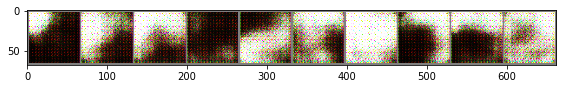

Epoch 0 	Batch 100 	Accuracy 0.925
Epoch 0 	Batch 101 	Accuracy 0.91
Epoch 0 	Batch 102 	Accuracy 0.985
Epoch 0 	Batch 103 	Accuracy 0.995
Epoch 0 	Batch 104 	Accuracy 0.995
Epoch 0 	Batch 105 	Accuracy 0.995
Epoch 0 	Batch 106 	Accuracy 0.985
Epoch 0 	Batch 107 	Accuracy 0.985
Epoch 0 	Batch 108 	Accuracy 0.855
Epoch 0 	Batch 109 	Accuracy 0.665
Epoch 0 	Batch 110 	Accuracy 0.51
Epoch 0 	Batch 111 	Accuracy 0.96
Epoch 0 	Batch 112 	Accuracy 0.68
Epoch 0 	Batch 113 	Accuracy 0.89
Epoch 0 	Batch 114 	Accuracy 0.98
Epoch 0 	Batch 115 	Accuracy 0.775
Epoch 0 	Batch 116 	Accuracy 0.8200000000000001
Epoch 0 	Batch 117 	Accuracy 0.935
Epoch 0 	Batch 118 	Accuracy 0.995
Epoch 0 	Batch 119 	Accuracy 0.9500000000000001
Epoch 0 	Batch 120 	Accuracy 0.9400000000000001
Epoch 0 	Batch 121 	Accuracy 0.845
Epoch 0 	Batch 122 	Accuracy 0.625
Epoch 0 	Batch 123 	Accuracy 0.65
Epoch 0 	Batch 124 	Accuracy 0.845
Epoch 0 	Batch 125 	Accuracy 0.96
Epoch 0 	Batch 126 	Accuracy 0.9500000000000001
Epoch 0 	Ba

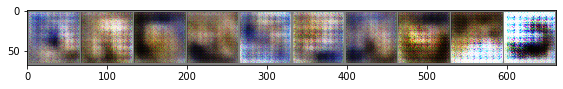

Epoch 0 	Batch 200 	Accuracy 0.71
Epoch 0 	Batch 201 	Accuracy 0.78
Epoch 0 	Batch 202 	Accuracy 0.87
Epoch 0 	Batch 203 	Accuracy 0.87
Epoch 0 	Batch 204 	Accuracy 0.775
Epoch 0 	Batch 205 	Accuracy 0.73
Epoch 0 	Batch 206 	Accuracy 0.745
Epoch 0 	Batch 207 	Accuracy 0.73
Epoch 0 	Batch 208 	Accuracy 0.68
Epoch 0 	Batch 209 	Accuracy 0.735
Epoch 0 	Batch 210 	Accuracy 0.855
Epoch 0 	Batch 211 	Accuracy 0.77
Epoch 0 	Batch 212 	Accuracy 0.885
Epoch 0 	Batch 213 	Accuracy 0.77
Epoch 0 	Batch 214 	Accuracy 0.76
Epoch 0 	Batch 215 	Accuracy 0.715
Epoch 0 	Batch 216 	Accuracy 0.835
Epoch 0 	Batch 217 	Accuracy 0.86
Epoch 0 	Batch 218 	Accuracy 0.795
Epoch 0 	Batch 219 	Accuracy 0.595
Epoch 0 	Batch 220 	Accuracy 0.62
Epoch 0 	Batch 221 	Accuracy 0.55
Epoch 0 	Batch 222 	Accuracy 0.715
Epoch 0 	Batch 223 	Accuracy 0.9
Epoch 0 	Batch 224 	Accuracy 0.915
Epoch 0 	Batch 225 	Accuracy 0.9500000000000001
Epoch 0 	Batch 226 	Accuracy 0.9
Epoch 0 	Batch 227 	Accuracy 0.8300000000000001
Epoch 0 	Ba

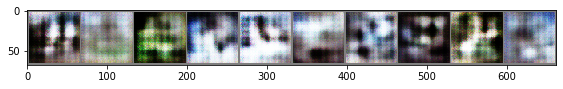

Epoch 0 	Batch 300 	Accuracy 0.6950000000000001
Epoch 0 	Batch 301 	Accuracy 0.705
Epoch 0 	Batch 302 	Accuracy 0.745
Epoch 0 	Batch 303 	Accuracy 0.73
Epoch 0 	Batch 304 	Accuracy 0.8250000000000001
Epoch 0 	Batch 305 	Accuracy 0.785
Epoch 0 	Batch 306 	Accuracy 0.8150000000000001
Epoch 0 	Batch 307 	Accuracy 0.85
Epoch 0 	Batch 308 	Accuracy 0.8250000000000001
Epoch 0 	Batch 309 	Accuracy 0.915
Epoch 0 	Batch 310 	Accuracy 0.885
Epoch 0 	Batch 311 	Accuracy 0.775
Epoch 0 	Batch 312 	Accuracy 0.585
Epoch 0 	Batch 313 	Accuracy 0.515
Epoch 0 	Batch 314 	Accuracy 0.58
Epoch 0 	Batch 315 	Accuracy 0.84
Epoch 0 	Batch 316 	Accuracy 0.585
Epoch 0 	Batch 317 	Accuracy 0.715
Epoch 0 	Batch 318 	Accuracy 0.8300000000000001
Epoch 0 	Batch 319 	Accuracy 0.79
Epoch 0 	Batch 320 	Accuracy 0.775
Epoch 0 	Batch 321 	Accuracy 0.78
Epoch 0 	Batch 322 	Accuracy 0.775
Epoch 0 	Batch 323 	Accuracy 0.775
Epoch 0 	Batch 324 	Accuracy 0.8
Epoch 0 	Batch 325 	Accuracy 0.885
Epoch 0 	Batch 326 	Accuracy 0.77

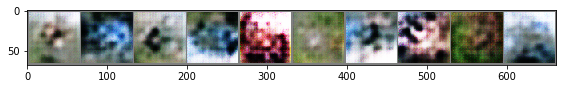

Epoch 0 	Batch 400 	Accuracy 0.88
Epoch 0 	Batch 401 	Accuracy 0.785
Epoch 0 	Batch 402 	Accuracy 0.775
Epoch 0 	Batch 403 	Accuracy 0.685
Epoch 0 	Batch 404 	Accuracy 0.77
Epoch 0 	Batch 405 	Accuracy 0.8200000000000001
Epoch 0 	Batch 406 	Accuracy 0.795
Epoch 0 	Batch 407 	Accuracy 0.79
Epoch 0 	Batch 408 	Accuracy 0.745
Epoch 0 	Batch 409 	Accuracy 0.52
Epoch 0 	Batch 410 	Accuracy 0.59
Epoch 0 	Batch 411 	Accuracy 0.89
Epoch 0 	Batch 412 	Accuracy 0.72
Epoch 0 	Batch 413 	Accuracy 0.66
Epoch 0 	Batch 414 	Accuracy 0.71
Epoch 0 	Batch 415 	Accuracy 0.615
Epoch 0 	Batch 416 	Accuracy 0.67
Epoch 0 	Batch 417 	Accuracy 0.795
Epoch 0 	Batch 418 	Accuracy 0.915
Epoch 0 	Batch 419 	Accuracy 0.63
Epoch 0 	Batch 420 	Accuracy 0.595
Epoch 0 	Batch 421 	Accuracy 0.62
Epoch 0 	Batch 422 	Accuracy 0.765
Epoch 0 	Batch 423 	Accuracy 0.85
Epoch 0 	Batch 424 	Accuracy 0.915
Epoch 0 	Batch 425 	Accuracy 0.91
Epoch 0 	Batch 426 	Accuracy 0.845
Epoch 0 	Batch 427 	Accuracy 0.8250000000000001
Epoch 0 

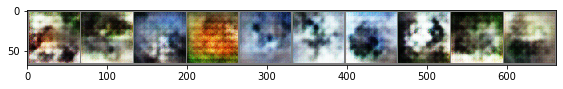

Epoch 1 	Batch 0 	Accuracy 0.755
Epoch 1 	Batch 1 	Accuracy 0.755
Epoch 1 	Batch 2 	Accuracy 0.6950000000000001


KeyboardInterrupt: 

In [10]:
# Training parameters
n_epochs = 1000
global_step = 0

# Training loop
for epoch in range(n_epochs):
    for batch_id, (real_batch,_) in enumerate(data_loader):
        # Generate real data
        real_data = real_batch.to(device)
        
        # Generate fake data
        noise = generate_noise(real_batch.size(0))
        fake_data = generator(noise).detach()
        
        # Train discriminator first
        d_error, prediction_real, prediction_fake, acc = train_discriminator(d_optimizer, real_data, fake_data)
        
        # Generate a new batch of fake data
        noise = generate_noise(real_batch.size(0))
        fake_data = generator(noise)
        
        # Train generator
        g_error = train_generator(g_optimizer, fake_data)
        
        # Log data
        print("Epoch", epoch, "\tBatch", batch_id, "\tAccuracy", acc.item())
        writer.add_scalar("discriminator_accuracy", acc, global_step)
        writer.add_scalar("discriminator_error", d_error, global_step)
        writer.add_scalar("generator_error", g_error, global_step)
        global_step += 1
        
        if batch_id % save_interval == (save_interval - 1):
            # Periodically check on the generator
            with torch.no_grad():
                noise = generate_noise(10)
                fake_images = generator(noise).cpu()
                grid = utils.make_grid(fake_images, nrow=10).permute(1, 2, 0)
                imshow(grid)

            # Save models' parameters
            torch.save(discriminator.state_dict(), d_save_path)
            torch.save(generator.state_dict(), g_save_path)